In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
%matplotlib inline
import os
import math
import scipy.integrate as integrate
import time
import sys
import matplotlib.patches as mpatches
import gc
import copy
from datetime import datetime
import time
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

In [167]:
class pmtunit:

    def gauss(self, x, a1, b1, s1):
        return a1 * np.exp(-(x-b1)**2/(2*s1**2))

    def xgauss(self, x, a1, b1, s1):
        return a1 * x * np.exp(-(x-b1)**2/(2*s1**2))
    
    def doublegauss(self, x, a1, b1, s1, a2, b2, s2):
        return a1 * np.exp(-(x-b1)**2/(2*s1**2)) + a2 * np.exp(-(x-b2)**2/(2*s2**2))
    
    def __init__(self, areas, pmt = 0, voltage = 0, name = 'unspecified'):
        self.areas = list(areas)
        self.gain = 0
        self.pstat = 0
        self.pmt = pmt
        self.voltage = voltage
        self.name = name
        self.method = 'none'
        self.doublegauss_popt = []
        self.gainerr = 0
        
    def info(self):
        print('     name: ' + self.name)
        print('  voltage: ' + str(self.voltage) + 'V')
        print('      pmt: ' + str(self.pmt))
        print('   method: ' + str(self.method))
        print('     gain: ' + str(round(self.gain,3)))
        print('  gainerr: ' + str(round(self.gainerr,3)))
        print('  poisson: ' + str(round(self.pstat*100, 1)) + '%')
        return
        
    def singlegaussfit(self, histbounds = [0,50], histbinwidth = 0.5, plot_xmax = 30, sigma_guess = 4, 
                       lmint = 1.1, lmaxt = 0.9, minmax_ratio_threshold = 1.1, diagnostic_plots = False, 
                       righthand_ratio = 1.5, lefthand_ratio = 0.8):
        
        histbins = np.arange(histbounds[0], histbounds[1]+histbinwidth/2.0, histbinwidth)
        centers = np.arange(histbounds[0]+histbinwidth/2.0, histbounds[1], histbinwidth)
        hist = plt.hist(self.areas, bins=histbins, histtype='step', color = 'blue')
        counts = hist[0]
        countserr = [np.sqrt(c+1) for c in counts]
        
        min_area = 0
        min_counts = counts[0]

        for pos in range(len(centers)):
            if counts[pos] < min_counts:
                min_counts = counts[pos]
                min_area = centers[pos]
                min_pos = pos
            if counts[pos] > lmint*min_counts:
                break
                
        max_area = 0
        max_counts = min_counts
        max_pos = min_pos

        for pos in range(min_pos, len(centers)):
            if counts[pos] > max_counts:
                max_counts = counts[pos]
                max_area = centers[pos]
                max_pos = pos
            if counts[pos] < lmaxt*max_counts:
                break
                
        if not min_area and max_area:
            print('ABORT: could not find local minimum and maximum')
            plt.clf()
            plt.cla()
            plt.close()
            return
        
        ymax = max_counts*1.2
        right_pos = max_pos + int(righthand_ratio*(max_pos-min_pos))
        left_pos = max_pos - int(lefthand_ratio*(max_pos-min_pos))
        right_area = centers[right_pos]
        left_area = centers[left_pos]
        
        if diagnostic_plots:
            plt.xlabel("Area (10^6 electrons)")
            plt.ylabel("Counts")
            plt.axvline(x = min_area, linewidth = 1, color = 'red')
            plt.axvline(x = max_area, linewidth = 1, color = 'red')
            plt.axvline(x = right_area, linewidth = 1, color = 'green')
            plt.axvline(x = left_area, linewidth = 1, color = 'green')
            plt.yscale('log')
            plt.xlim(0, plot_xmax)
            plt.show()
            
        if not max_area > minmax_ratio_threshold*min_area:
            print('ABORT: spurious maximum and minimum found')
            plt.clf()
            plt.cla()
            plt.close()
            return
        if not min_counts > 10:
            print('ABORT: spurious maximum and minimum found')
            plt.clf()
            plt.cla()
            plt.close()
            return
        

        centerscut = [centers[i] for i in range(len(centers)) if (i>=min_pos and i<=right_pos)]
        countscut = [counts[i] for i in range(len(counts)) if (i>=min_pos and i<=right_pos)]
        countserrcut = [countserr[i] for i in range(len(countserr)) if (i>=min_pos and i<=right_pos)]
        
        try:
            popt, pcov = curve_fit(self.gauss, centerscut, countscut, sigma = countserrcut, absolute_sigma=False, p0=[max_counts, max_area, sigma_guess])
        except RuntimeError:
            print(self.name + ' ' + str(self.voltage) + 'V ' + 'PMT' + str(self.pmt) + ' singlegauss fit failed to converge, aborting gain calculation.')
            return
        
        perr = np.sqrt(np.diag(pcov))
        af, bf, sf = popt
        
        if diagnostic_plots:
            fitcounts = [self.gauss(t, popt[0], popt[1], popt[2]) for t in centers]
            plt.plot(centers, fitcounts, color='red', linewidth = 1)
            plt.errorbar(centers, counts, yerr = countserr, fmt = '.', markersize = 4)
            plt.xlabel("Area (10^6 electrons)")
            plt.ylabel("Counts")
            plt.axvline(x = min_area, linewidth = 1, color = 'red')
            plt.axvline(x = max_area, linewidth = 1, color = 'red')
            plt.axvline(x = right_area, linewidth = 1, color = 'green')
            plt.axvline(x = left_area, linewidth = 1, color = 'green')
            plt.xlim(0, plot_xmax)
            plt.ylim(0, ymax)
            plt.show()
            
        totalgral = integrate.quad(self.gauss, 0, np.inf, args = (af, bf, sf))[0]
        totalsignal = totalgral / histbinwidth
        self.gain = integrate.quad(self.xgauss, 0, np.inf, args = (af, bf, sf))[0]/totalgral
        self.pstat = totalsignal / len(self.areas)
        relerr = ((perr[-2]/popt[-2])**2)**(1./2)
        self.gainerr = relerr * self.gain
        plt.clf()
        plt.cla()
        plt.close()
        self.method = 'singlegauss'
        return
    
    def doublegaussfit(self, histbounds = [-0.5, 25], histbinwidth = 0.1, diagnostic_plots = False, popt_guess = [1e5, 0, 0.5, 5e3, 1, 1.5]):
        
        a1g, b1g, s1g, a2g, b2g, s2g = popt_guess
        
        histbins = np.arange(histbounds[0], histbounds[1]+histbinwidth/2.0, histbinwidth)
        centers = np.arange(histbounds[0]+histbinwidth/2.0, histbounds[1], histbinwidth)
        hist = plt.hist(self.areas, bins=histbins, histtype='step', color = 'red')
        counts = hist[0]
        countserr = [np.sqrt(t)+1 for t in counts]
        gescounts = [self.doublegauss(t, a1g, b1g, s1g, a2g, b2g, s2g) for t in centers]
        
        if diagnostic_plots:
            plt.plot(centers, gescounts, color='black', linewidth = 1)
            plt.ylabel('Gain (*10^6)')
            plt.ylabel("Counts")
            plt.yscale('log')
            plt.ylim(1, 2*max(counts))
            plt.show()
            
        try:
            popt, pcov = curve_fit(self.doublegauss, centers, counts, sigma = countserr, absolute_sigma=False, p0=[a1g, b1g, s1g, a2g, b2g, s2g])
        except RuntimeError:
            print(self.name + ' ' + str(self.voltage) + 'V ' + 'PMT' + str(self.pmt) + ' doublegauss fit failed to converge, aborting gain calculation.')
            return
        
        perr = np.sqrt(np.diag(pcov))

        fitcounts = [self.doublegauss(t, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5]) for t in centers]
        noscounts = [self.gauss(t, popt[0], popt[1], popt[2]) for t in centers]
        sigcounts = [self.gauss(t, popt[3], popt[4], popt[5]) for t in centers]
        
        if diagnostic_plots:
            plt.plot(centers, noscounts, color='green', linewidth = 1)
            plt.plot(centers, sigcounts, color='green', linewidth = 1)
            plt.errorbar(centers, counts, yerr = countserr, fmt = '.', markersize = 4)
            plt.plot(centers, fitcounts, color='red', linewidth = 1)
            plt.plot(centers, gescounts, color='black', linewidth = 1)
            plt.ylabel('Gain (*10^6)')
            plt.ylabel("Counts")
            plt.yscale('log')
            plt.ylim(1, 2*max(counts))
            plt.show()
        
        totalgral = integrate.quad(self.gauss, 0, np.inf, args = (popt[3], popt[4], popt[5]))[0]
        if totalgral == 0:
            print('ERROR: totalgral = 0')
            self.gain = 0
            plt.clf()
            plt.cla()
            plt.close()
            return
        totalsignal = totalgral / histbinwidth
        self.gain = integrate.quad(self.xgauss, 0, np.inf, args = (popt[3], popt[4], popt[5]))[0]/totalgral
        self.pstat = totalsignal / len(self.areas)
        relerr = ((perr[-2]/popt[-2])**2)**(1./2)
        self.gainerr = relerr * self.gain
        plt.clf()
        plt.cla()
        plt.close()
        self.method = 'doublegauss'
        self.doublegauss_popt = popt
        return
        

In [168]:
class pmt_cluster:
    
    def gainexp(self, x, a, d):
        return a*2**((x-1000)/d)
    
    def gainexperr(self, x, a, aerr, d, derr):
        return 2**((x-1000)/d)*np.sqrt((a*np.log(2)*(x-1000)*d**(-2)*derr)**2 + aerr**2)
    
    def gaincalculator(self, set_name = '', voltage = ''):
        a    = self.setfits[set_name]['a']
        aerr = self.setfits[set_name]['aerr']
        d    = self.setfits[set_name]['d']
        derr = self.setfits[set_name]['derr']
        x = voltage
        gain = self.gainexp(x, a, d)
        gainerr = self.gainexperr(x, a, aerr, d, derr)
        print("Expected gain is " + str(round(gain, 3)) + " +-" + str(round(gainerr, 3)))
        return 
    
    def __init__(self):
        self.unitlist = []
        self.setnames = []
        self.setvoltages = {}
        self.setgains = {}
        self.setgainerrs = {}
        self.setfits = {}
        self.setcolors = {}
        
    def calcsetdata(self):
        for name in self.setnames:
            self.setvoltages[name] = []
            self.setgains[name] = []
            self.setgainerrs[name] = []
            self.setfits[name] = {}
        for unit in self.unitlist:
            self.setvoltages[unit.name+'PMT'+str(unit.pmt)].append(unit.voltage)
            self.setgains[unit.name+'PMT'+str(unit.pmt)].append(unit.gain)
            self.setgainerrs[unit.name+'PMT'+str(unit.pmt)].append(unit.gainerr)
            
    def add_run(self, directory, start='', end='', voltages = [], pmt1channel = 3, pmt2channel = 0, run_name = 'unspecified', color = 'black'):
        measlist = []
        dirlist = list(os.listdir(directory))
        dirlist.sort()
        for thing in dirlist:
            if thing[-5:] != '.hdf5':
                break
            thing = thing[:-5]
            if thing >= start and thing <= end:
                measlist.append(thing)
        print('loading ' + str(len(measlist)) + ' measurements...')
        print(measlist)
        if len(measlist) != len(voltages):
            print('ERROR: Number of runs not equal to number of voltages!!!')
            return
        for meas, voltage in zip(measlist, voltages):
            print('loading ' + meas + '...')
            store = pd.HDFStore(directory + meas + '.hdf5')
            data = store['all_hits']
            datapmt1 = data[data['channel'] == pmt1channel]
            datapmt2 = data[data['channel'] == pmt2channel]
            melecs1 = datapmt1['area']/1e6
            melecs2 = datapmt2['area']/1e6
            unit1 = pmtunit(melecs1, pmt = 1, voltage = voltage, name = run_name)
            unit2 = pmtunit(melecs2, pmt = 2, voltage = voltage, name = run_name)
            self.unitlist.append(unit1)
            self.unitlist.append(unit2)
            store.close()
            gc.collect()
        self.setnames.append(run_name+'PMT1')
        self.setnames.append(run_name+'PMT2')
        self.setcolors[run_name+'PMT1'] = color
        self.setcolors[run_name+'PMT2'] = color
        self.sort_units()
        print('all done')
        return
    
    def calc_gains(self, run_name, diagnostic_plots = False, popt_guess = [1e5, 0, 0.5, 5e3, 1, 1.5]):
        fitted_gains = 0
        total_gains = 0;
        for pmt in [1,2]:
            failed_single_yet = False
            popt = copy.deepcopy(popt_guess)
            for unit in self.unitlist:
                if (unit.name == run_name) and (unit.pmt == pmt):
                    print(str(unit.voltage) + 'V for PMT ' + str(unit.pmt))
                    if not failed_single_yet:
                        unit.singlegaussfit(diagnostic_plots = diagnostic_plots)
                    if unit.gain==0:
                        failed_single_yet = True
                        unit.doublegaussfit(diagnostic_plots = diagnostic_plots, popt_guess = popt)
                        if unit.gain!=0:
                            popt = copy.deepcopy(unit.doublegauss_popt)
                    if unit.gain!=0:
                        fitted_gains+=1
                    total_gains+=1
        print('succesfully fitted ' + str(fitted_gains) + ' out of ' + str(total_gains) + ' gains')
        return
    
    def plot_gains(self, run_names, pmts = [1,2]):
        patches = []
        for run_name in run_names:
            for pmt in pmts:
                voltages = []
                gains = []
                gainerrs = []
                markers = []
                for unit in self.unitlist:
                    if (unit.name == run_name) and (unit.pmt == pmt):
                        if unit.gain!=0:
                            voltages.append(unit.voltage)
                            gains.append(unit.gain)
                            gainerrs.append(unit.gainerr)
                            markers.append('X')
                            if unit.method == 'singlegauss':
                                markers[-1] = 'o'
                            if unit.method == 'doublegauss':
                                markers[-1] = ''
                color = self.setcolors[run_name+'PMT'+str(pmt)]
                for i in range(len(voltages)):
                    plt.errorbar([voltages[i]], [gains[i]], yerr=[gainerrs[i]], marker = markers[i], markersize = 5, color = color)
                plt.plot(voltages, gains, color = color)
                patches.append(mpatches.Patch(color = color, label=run_name + " PMT" + str(pmt)))
        plt.legend(handles=patches, loc=2)
        plt.yscale('log')
        plt.ylim(0.1, 100)
        plt.xlim(775, 1025)
        plt.xlabel('Potential (V)')
        plt.ylabel('Gain (*10^6)')
        return

    def fitgains(self, set_names = [], diagnostic_plots = False, fitall=False):
        self.calcsetdata()
        if fitall:
            set_names = self.setnames
        for set_name in set_names:
            voltages = self.setvoltages[set_name]
            gains = self.setgains[set_name]
            gainerrs = self.setgainerrs[set_name]
            sel = [i for i in range(len(gains)) if gains[i]>0]
            voltages = [voltages[i] for i in sel]
            gains = [gains[i] for i in sel]
            gainerrs = [gainerrs[i] for i in sel]
            
            if len(sel)<2:
                print('ABORT: ' + set_name + ' has insufficient datapoints for fit')
                return

            try:
                popt, pcov = curve_fit(self.gainexp, voltages, gains, sigma = gainerrs, absolute_sigma=True, p0=[15, 50])
            except RuntimeError:
                print(set_name + ' gain fit failed to converge, aborting fit.')
                return
            
            perr = np.sqrt(np.diag(pcov))
            
#             if len(sel)==2:
#                 print('WARNING: ' + set_name + 'has insufficient datapoints for error estimate. Error = 0.')
#                 perr = [0,0]
                
            if diagnostic_plots:
                guess = [self.gainexp(x, 15, 50) for x in voltages]
                fit = [self.gainexp(x, popt[0], popt[1]) for x in voltages]
    #             plt.plot(voltages, guess, color = 'grey')
                plt.plot(voltages, fit, color = 'green')
                plt.errorbar(voltages, gains, gainerrs, linewidth = 0, marker = '.', color = 'red')
                plt.yscale('log')
                plt.ylim(0.1, 100)
                plt.xlim(775, 1025)
                plt.xlabel('Potential (V)')
                plt.ylabel('Gain (*10^6)')
                plt.show()

            self.setfits[set_name]['a'] = popt[0]
            self.setfits[set_name]['aerr'] = perr[0]
            self.setfits[set_name]['d'] = popt[1]
            self.setfits[set_name]['derr'] = perr[1]
            print(set_name + ' gain fit successful, a = ' + str(round(popt[0], 2)) + '+-' + str(round(perr[0], 2)) + ', d = ' + str(round(popt[1], 2))+ '+-' + str(round(perr[1], 2)))
        return
            
    def sort_units(self):
        self.unitlist = sorted(self.unitlist, key=lambda x: x.pmt)
        self.unitlist = sorted(self.unitlist, key=lambda x: x.voltage, reverse = True)
        self.unitlist = sorted(self.unitlist, key=lambda x: x.name)
    
    def gainovertime(self, pmts = [1,2], colors = {'1': 'black', '2': 'red'}):
        patches = []
        for pmt in pmts:
            days = []
            gains = []
            gainerrs = []
            for set_name in self.setnames:
                if set_name[-1] == str(pmt):
                    days.append(int(datetime.strptime(set_name[:-4], "%y%m%d").timestamp()/86400))
                    gains.append(self.setfits[set_name]['a'])
                    gainerrs.append(self.setfits[set_name]['aerr'])
            days = [day - days[0] for day in days]
            plt.errorbar(days, gains, yerr=gainerrs, color = colors[str(pmt)])
            patches.append(mpatches.Patch(color = colors[str(pmt)], label="PMT" + str(pmt)))
        plt.ylim(5, 25)
        plt.xlim(-5, 50)
        plt.xlabel('Time (days)')
        plt.ylabel('Fitted gain (*10^6) (1000V equivalent)')
        plt.legend(handles=patches, loc=1)  
        return

In [169]:
# dirname = '/Users/Kiefer/Desktop/Jupyter/PMTcal/pmtdata/'
dirname = '/mnt/windrive/Jupyter/PMTcal/proc/'
pmtcluster = pmt_cluster()

In [170]:
voltages = [800, 825, 850, 875, 900, 925, 950, 975, 1000]
pmtcluster.add_run(dirname, start = 'K0800_170201_122330', end = 'K1000_170201_104425', voltages = voltages, run_name = '170201', color = 'red')

loading 9 measurements...
['K0800_170201_122330', 'K0825_170201_121820', 'K0850_170201_121200', 'K0875_170201_120645', 'K0900_170201_100310', 'K0925_170201_120105', 'K0950_170201_105510', 'K0975_170201_104940', 'K1000_170201_104425']
loading K0800_170201_122330...
loading K0825_170201_121820...
loading K0850_170201_121200...
loading K0875_170201_120645...
loading K0900_170201_100310...
loading K0925_170201_120105...
loading K0950_170201_105510...
loading K0975_170201_104940...
loading K1000_170201_104425...
all done


In [171]:
voltages = [1000, 950, 900, 850, 800, 825, 875, 925, 975]
pmtcluster.add_run(dirname, start = '170313_100816', end = '170313_105859', voltages = voltages, run_name = '170313', color = 'orange')

loading 9 measurements...
['170313_100816', '170313_101418', '170313_101924', '170313_102507', '170313_102951', '170313_103526', '170313_104009', '170313_105341', '170313_105859']
loading 170313_100816...
loading 170313_101418...
loading 170313_101924...
loading 170313_102507...
loading 170313_102951...
loading 170313_103526...
loading 170313_104009...
loading 170313_105341...
loading 170313_105859...
all done


In [172]:
voltages = [1000, 975, 950, 925, 900, 875, 850, 825, 800]
pmtcluster.add_run(dirname, start = '170323_101402', end = '170323_105859', voltages = voltages, run_name = '170323', color = 'green')

loading 9 measurements...
['170323_101402', '170323_101951', '170323_102550', '170323_103101', '170323_103732', '170323_104243', '170323_104831', '170323_105351', '170323_105859']
loading 170323_101402...
loading 170323_101951...
loading 170323_102550...
loading 170323_103101...
loading 170323_103732...
loading 170323_104243...
loading 170323_104831...
loading 170323_105351...
loading 170323_105859...
all done


In [173]:
voltages = [1000, 950, 900, 850, 800, 825, 875, 925, 975]
pmtcluster.add_run(dirname, start = '170327_142511', end = '170327_150818', voltages = voltages, run_name = '170327', color = 'cyan')

loading 9 measurements...
['170327_142511', '170327_143147', '170327_143657', '170327_144150', '170327_144712', '170327_145151', '170327_145731', '170327_150258', '170327_150818']
loading 170327_142511...
loading 170327_143147...
loading 170327_143657...
loading 170327_144150...
loading 170327_144712...
loading 170327_145151...
loading 170327_145731...
loading 170327_150258...
loading 170327_150818...
all done


In [174]:
voltages = [1000, 975, 950, 925, 900, 875, 850, 825, 800]
pmtcluster.add_run(dirname, start = '170404_112004', end = '170404_121155', voltages = voltages, run_name = '170404', color = 'blue')

loading 9 measurements...
['170404_112004', '170404_112627', '170404_113136', '170404_113644', '170404_114542', '170404_115217', '170404_115739', '170404_120410', '170404_121155']
loading 170404_112004...
loading 170404_112627...
loading 170404_113136...
loading 170404_113644...
loading 170404_114542...
loading 170404_115217...
loading 170404_115739...
loading 170404_120410...
loading 170404_121155...
all done


In [175]:
pmtcluster.calc_gains('170201', diagnostic_plots = False)
pmtcluster.calc_gains('170313', diagnostic_plots = False)
pmtcluster.calc_gains('170323', diagnostic_plots = False)
pmtcluster.calc_gains('170327', diagnostic_plots = False)
pmtcluster.calc_gains('170404', diagnostic_plots = False)

1000V for PMT 1
975V for PMT 1
950V for PMT 1
925V for PMT 1
900V for PMT 1
875V for PMT 1
850V for PMT 1
ABORT: spurious maximum and minimum found
825V for PMT 1
800V for PMT 1
1000V for PMT 2
975V for PMT 2
950V for PMT 2
ABORT: spurious maximum and minimum found
925V for PMT 2
900V for PMT 2
875V for PMT 2
850V for PMT 2
825V for PMT 2
800V for PMT 2
succesfully fitted 18 out of 18 gains
1000V for PMT 1
975V for PMT 1
950V for PMT 1
925V for PMT 1
900V for PMT 1
875V for PMT 1
ABORT: spurious maximum and minimum found
850V for PMT 1
825V for PMT 1
800V for PMT 1
1000V for PMT 2
975V for PMT 2
950V for PMT 2
925V for PMT 2
ABORT: spurious maximum and minimum found
900V for PMT 2
875V for PMT 2
850V for PMT 2
825V for PMT 2
800V for PMT 2
succesfully fitted 18 out of 18 gains
1000V for PMT 1
975V for PMT 1
950V for PMT 1
ABORT: spurious maximum and minimum found
925V for PMT 1
900V for PMT 1
875V for PMT 1
850V for PMT 1
825V for PMT 1
800V for PMT 1
1000V for PMT 2
975V for PMT 2
950

/home/kiefer/anaconda3/lib/python3.5/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [176]:
#UGLY FIX FOR WEIRD PMT1 RESULTS
for unit in pmtcluster.unitlist:
    if unit.name == '170323' or unit.name == '170327':
        if unit.pmt == 1 and unit.gain < 5:
            unit.gain = 0

/home/kiefer/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


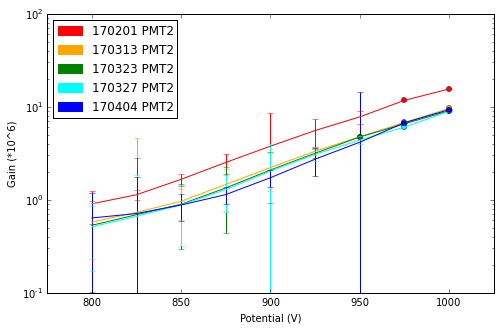

In [188]:
pmtcluster.plot_gains(['170201', '170313', '170323', '170327', '170404'], pmts=[2])
# plt.savefig('gains2.pdf', format = 'pdf')


In [185]:
pmtcluster.fitgains(fitall = True, diagnostic_plots=False)

170201PMT1 gain fit successful, a = 21.31+-0.1, d = 54.37+-0.28
170201PMT2 gain fit successful, a = 15.79+-0.11, d = 52.13+-1.31
170313PMT1 gain fit successful, a = 18.89+-0.08, d = 55.33+-0.45
170313PMT2 gain fit successful, a = 9.62+-0.1, d = 49.26+-1.2
170323PMT1 gain fit successful, a = 18.97+-0.14, d = 63.27+-3.19
170323PMT2 gain fit successful, a = 9.1+-0.14, d = 52.34+-2.2
170327PMT1 gain fit successful, a = 19.28+-0.2, d = 54.46+-1.87
170327PMT2 gain fit successful, a = 8.9+-0.16, d = 46.22+-2.88
170404PMT1 gain fit successful, a = 19.19+-0.11, d = 57.03+-0.73
170404PMT2 gain fit successful, a = 9.37+-0.09, d = 47.58+-1.99


/home/kiefer/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


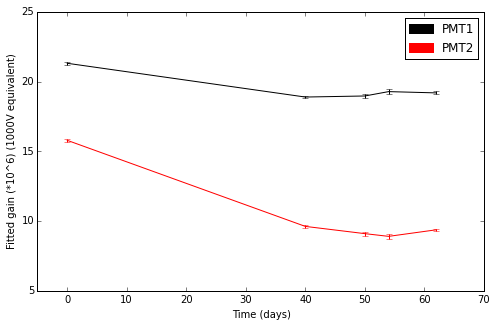

In [187]:
pmtcluster.gainovertime()
plt.xlim(-5,70)
# plt.savefig('gainovertime.pdf', format = 'pdf')
plt.show()

In [183]:
pmtcluster.gaincalculator(set_name = '170404PMT1', voltage = 675)
pmtcluster.gaincalculator(set_name = '170404PMT2', voltage = 725)

Expected gain is 0.369 +-0.019
Expected gain is 0.171 +-0.029
